In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os
from create_analyze_runs_helpers import *

### Experiment settings

In [9]:
def small_setting():
    # SMALL setting experiments
    setting_name = 'small'
    common = {'image_side': 4, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 1, 'architecture': '20_10'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 1.0, 'epochs': 100, **common}],

        'frankwolfe':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'p': 2.0, 'R': 100.0, 'gamma': -1.0, 'ro': -1.0,
         'epochs': 100, **common}],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'p': 2.0, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 100, **common}],
    }
    return setting_name, common, param_groups

In [10]:
def medium_setting():
    # medium setting
    setting_name = 'medium_auto'
    common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 100, **common}
         for lr in [0.1, 0.01, 0.001, 0.0001]],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
         'epochs': 100, **common} for gamma in [-1.] + [0.1, 0.5, 1.]
         for ro in [-1.] + list(np.linspace(0, 1, 3))],

            'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
         'epochs': 500, **common} for gamma in [-1.] + [0.1, 0.3, 0.5]],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 100, **common} for lr in [0.1, 0.01, 0.001, 0.0001]]
    }
    return setting_name, common, param_groups

In [11]:
def big_setting():
    # BIG setting
    setting_name = 'big'
    common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 1000, **common}
         for lr in [1., 0.5, 0.1, 0.05]],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
         'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]
         for ro in [-1.] + [0.1, 0.3, 0.5]],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
         'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 1000, **common} for lr in [0.01, 0.001, 0.0001]]
    }
    return setting_name, common, param_groups

In [12]:
def batch_size_setting():
    # Medium 2 setting (batch size effect)
    setting_name = 'medium2'
    common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
    batches = [1000, 5000, 10000, 60000]
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': bs, 'learning_rate': 1.0, 'epochs': 1000, **common}
         for bs in batches],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': bs, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0,
         'epochs': 1000, **common} for bs in batches],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0,
         'epochs': 5000, **common}],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': bs, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 1000, **common} for bs in batches]
    }
    return setting_name, common, param_groups

### Choosing a setting

In [13]:
R = small_setting()
#R = medium_setting()
#R = big_setting()
#R = batch_size_setting()

In [14]:
# name of the setting, common parameters, parameter groups, all parameters
setting_name, common, param_groups = R
parameters = [x for group in param_groups.values() for x in group]

In [15]:
# group -> what changes
varying = {group: varying_for_optim(param_groups[group]) for group in param_groups.keys()}

print(varying)

{'sgd': [], 'frankwolfe': [], 'adam': []}


### Creating the `.sh` file

In [66]:
# writing the .sh file
write_sh_file(setting_name, parameters, common)

OUTPUT: ./output/run_small.sh
Total runs:  3
Total time (approx):  0.0625


### Processing data

In [56]:
# parameter id -> processed file
params_to_processed = []
done = 0
for param in parameters:
    fs = process_file(get_file(**param), 'loss_decay_' + setting_name + '_' + shorten_dict(param, filename = True), True)
    print(param)
    print(fs)
    print("-----")
    if fs is not None:
        done += 1
    params_to_processed.append(fs)
print('Done: %d/%d' % (done, len(parameters)))

!!! File  missing ./output/optimizer-sgd_architecture-20_20_image_side-10_giveup-100_accuracy_threshold-0.0_epochs-100_repetitions-1_train_batch_size-1000_R-None_gamma-None_p-None_ro-None_learning_rate-0.1_beta1-None_beta2-None_epsilon-None.output
{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 100, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1, 'architecture': '20_20'}
None
-----
!!! File  missing ./output/optimizer-frankwolfe_architecture-20_20_image_side-10_giveup-100_accuracy_threshold-0.0_epochs-200_repetitions-1_train_batch_size-1000_R-100.0_gamma-0.01_p-2.0_ro-0.6_learning_rate-None_beta1-None_beta2-None_epsilon-None.output
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'p': 2.0, 'R': 100.0, 'gamma': 0.01, 'ro': 0.6, 'epochs': 200, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1, 'architecture': '20_20'}
None
-----
!!! File  missing ./output/optimizer-adam_architecture-20_20_image_s

In [57]:
# all measured quantities
all_metrics = list(params_to_processed[0].keys())

# have 7 metrics
print(len(all_metrics))

AttributeError: 'NoneType' object has no attribute 'keys'

=== OPT sgd / METRIC train_loss ===
=== OPT sgd / METRIC test_loss ===
=== OPT sgd / METRIC train_acc ===
=== OPT sgd / METRIC test_acc ===
=== OPT sgd / METRIC p_norm ===
=== OPT sgd / METRIC hessian_eigens_mean ===
=== OPT sgd / METRIC hessian_eigens_Max ===


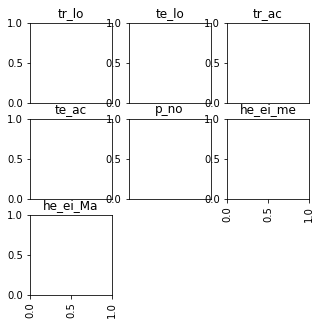

=== OPT frankwolfe / METRIC train_loss ===
=== OPT frankwolfe / METRIC test_loss ===
=== OPT frankwolfe / METRIC train_acc ===
=== OPT frankwolfe / METRIC test_acc ===
=== OPT frankwolfe / METRIC p_norm ===
=== OPT frankwolfe / METRIC hessian_eigens_mean ===
=== OPT frankwolfe / METRIC hessian_eigens_Max ===


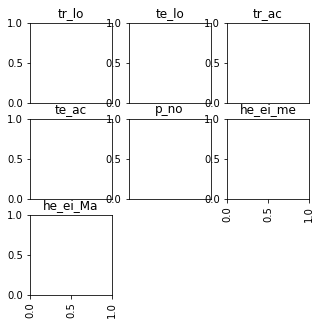

=== OPT adam / METRIC train_loss ===
=== OPT adam / METRIC test_loss ===
=== OPT adam / METRIC train_acc ===
=== OPT adam / METRIC test_acc ===
=== OPT adam / METRIC p_norm ===
=== OPT adam / METRIC hessian_eigens_mean ===
=== OPT adam / METRIC hessian_eigens_Max ===


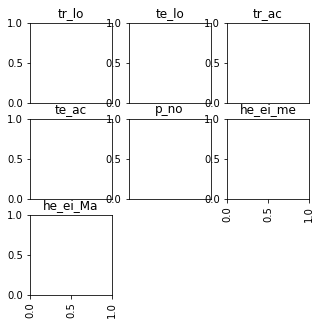

In [58]:
# printing all results (mean over runs/std)
for optim in param_groups.keys():
    data_for_metric = {}
    for m in all_metrics:
        print("=== OPT %s / METRIC %s ===" % (optim, m))
    
        # labels (parameters used)
        xs = []
        
        # values (arrays) for repetitions
        ys = []
    
        # going over parameters
        for p in param_groups[optim]:
            varying_params = dict_select(p, varying[optim])
            #print(varying_params)
            #print(dict_to_stat(param_to_result(p)))
            res = param_to_result(p, parameters, params_to_processed)
            if res is not None:
                ys.append(res[m])
                xs.append(shorten_dict(varying_params))
        data_for_metric[m] = (xs, ys)
        
    def plot_one(ax, i):
        """ Plot one box plot for metric i at axis ax """
        m = all_metrics[i] # current metric
        xs, ys = data_for_metric[m] # current data
        # plotting
        if xs:
            assert len(xs) == len(ys)
            ax.boxplot(ys, labels = xs)
    subplots(3, 3, all_metrics, plot_one, (5, 5))

### Batch size
Frank-Wolfe:batch size 1000-10K has almost no effect, a bit worse at 60K

Adam/SGD: Increase batch size -> decrease accuracy, increase loss. Hessian becomes a bit worse at 60K, but mostly decreases.

### Big

SGD: With decrease of learning rate, train/test accuracy decreases, loss increases, p-norm decreases and largest eigenvalues decrease. Choising LR=1

Frank-Wolfe Stochastic (g=-1). r = -1 gives best accuracy, constant rs are worse, the more the worse. p-norm decreases with accuracy, eigenvalues also decrease (max/mean). Constant gamma/rho give poor results

Frank-Wolfe deterministic: no data

Adam: with decrease of the learning rate, train accuracy decreases, sharp decrease for 0.0001. Hessian eigenvalues increase. Choosing LR = 0.001

In [49]:
# printing best parameters
for optim in param_groups.keys():
    idx = select_best(optim, parameters, param_groups, params_to_processed) # best hyperparameter idx
    p = parameters[idx] # best hyperparameters
    print(optim, dict_select(p, varying[optim]))

sgd {'learning_rate': 0.1}
frankwolfe_stochastic {'gamma': -1.0, 'ro': -1.0}
frankwolfe_deterministic {'gamma': -1.0}
adam {'learning_rate': 0.01}


In [50]:
# final result for all optimizers (best)
data_for_optimizers = {}

# loop over metrics
for m in all_metrics:
    xs = [] # optimizers
    ys = [] # data for optimizers

    # print final results
    for optim in param_groups.keys():
        idx = select_best(optim, parameters, param_groups, params_to_processed) # best hyperparameter
        p = params_to_processed[idx]
        if p is not None:
            xs.append(shorten_name(optim))
            ys.append(p[m])
    
    # saving data...
    data_for_optimizers[m] = (xs, ys)

<Figure size 432x288 with 0 Axes>

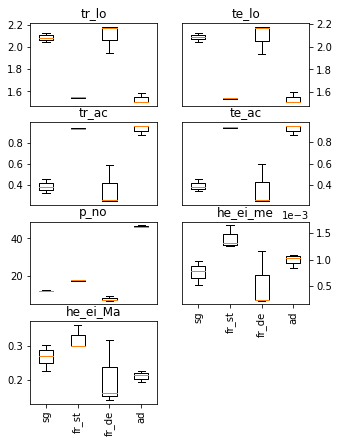

In [51]:
def plot_one(ax, i):
    """ Plot one box plot for metric i at axis ax """
    m = all_metrics[i] # current metric
    xs, ys = data_for_optimizers[m] # current data
    # plotting
    if xs:
        assert len(xs) == len(ys)
        ax.boxplot(ys, labels = xs)
    if i % 2 == 1:
        ax.yaxis.tick_right()
    if m == 'hessian_eigens_mean':
        #ax.yaxis.set_major_formatter(OOMFormatter(-4, "%1.1f"))
        ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
        pass
plt.subplots_adjust(wspace = 1)
subplots(4, 2, all_metrics, plot_one, (5, 7), 'best_' + setting_name)
plt.show()

### Batch size
Best accuracy: FW and Adam. Stochastic much better than deterministic for accuracy.

Hessian is a bit better for FW than for Adam

### Big

SGD: high variance, low Hessian

FW: high accuracy (a bit lower than Adam), low p-norm, high Hessian, hood generalization

Adam: highest accuracy, low variance, high p-norm, low Hessian, good generalization